In [2]:
import pandas as pd
import numpy as np
from typing import Union,List, Dict
import mysql.connector
from mysql.connector import Error
import psycopg2
from psycopg2 import Error
from credenciales_gamma import connection_params_gamma
from credentials_geo import connection_params_geo
from variables_by_sector import retail, office, industrial, land, sector_map, quality_map, photos_map, quality_map
from querys import query_qa_price_rent, query_qa_price_sale, query_qa_area

In [3]:
def execute_query_mysql(query: str, connection_params: dict) -> Union[pd.DataFrame, None]:
    """
    Execute a SQL query on the MySQL database and return the results as a pandas DataFrame.

    Args:
        query (str): SQL query to execute
        connection_params (dict): Connection parameters

    Returns:
        Union[pd.DataFrame, None]: DataFrame with query results or None if there was an error
    """
    try:
        # Connect to the database
        connection = mysql.connector.connect(**connection_params)
        
        # Create a cursor
        cursor = connection.cursor()
        
        # Execute the query
        cursor.execute(query)
        
        # If the query returns results, fetch them
        if cursor.description:
            columns = [desc[0] for desc in cursor.description]
            rows = cursor.fetchall()
            df = pd.DataFrame(rows, columns=columns)
            return df
        else:
            connection.commit()
            return None
            
    except Error as error:
        print(f"Error while connecting to MySQL: {error}")
        return None
        
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'connection' in locals():
            connection.close()

In [4]:
def execute_query_postgres(query: str, connection_params: dict) -> Union[pd.DataFrame, None]:
    """
    Execute a SQL query on the PostgreSQL database and return the results as a pandas DataFrame.
    
    Args:
        query (str): SQL query to execute
        
    Returns:
        Union[pd.DataFrame, None]: DataFrame with query results or None if there was an error
    """
    try:
        # Connection parameters
        
        # Connect to the database
        connection = psycopg2.connect(**connection_params)
        
        # Create a cursor
        cursor = connection.cursor()
        
        # Execute the query
        cursor.execute(query)
        
        # If the query returns results, fetch them
        if cursor.description:
            # Get column names
            columns = [desc[0] for desc in cursor.description]
            
            # Fetch all rows
            rows = cursor.fetchall()
            
            # Create DataFrame
            df = pd.DataFrame(rows, columns=columns)
            
            return df
        else:
            # For queries that don't return results (INSERT, UPDATE, DELETE)
            connection.commit()
            return None
            
    except (Exception, Error) as error:
        print(f"Error while connecting to PostgreSQL: {error}")
        return None
        
    finally:
        # Close the cursor and connection
        if 'cursor' in locals():
            cursor.close()
        if 'connection' in locals():
            connection.close()

In [5]:
distribucion_photos = """
select spot_id , spot_photo_platform_count
from lk_spots
where spot_status_id = 1
order by spot_photo_platform_count asc
"""
info = execute_query_postgres(distribucion_photos, connection_params_geo)

<Axes: >

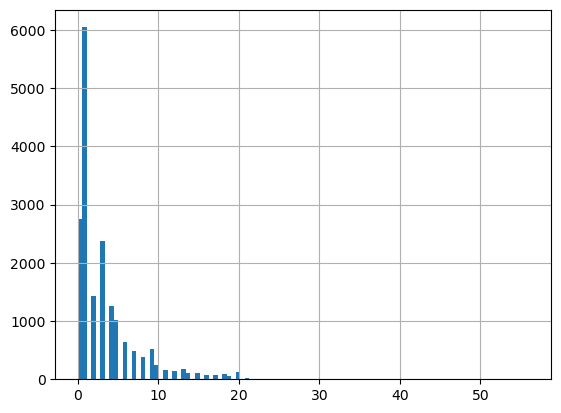

In [6]:
info['spot_photo_platform_count'].hist(bins=100)

In [7]:
info.head()

,spot_id,spot_photo_platform_count
0,16225,0
1,21927,0
2,21928,0
3,21929,0
4,21930,0


In [8]:
quantiles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

photo_quantile_map = {
    f"{int(q*100)}": info['spot_photo_platform_count'].quantile(q)
    for q in quantiles
}

print(photo_quantile_map)

{'10': 0.0, '20': 1.0, '30': 1.0, '40': 1.0, '50': 2.0, '60': 3.0, '70': 4.0, '80': 5.0, '90': 9.0}


In [9]:
def get_id_spot(id: int):
    id = id
    query_completitud = f"""
    SELECT 
    s.id AS spot_id,
    s.spot_type_id, 
    s.natural_light, 
    s.luminaries, 
    s.charging_ports, 
    s.energy, 
    s.floor_material, 
    s.fire_protection_system, 
    s.security_type, 
    s.vehicle_ramp, 
    s.land_use, 
    s.floor_level, 
    s.vertical_height, 
    s.parking_spaces, 
    s.front, 
    s.height, 
    s.height_between_floors,

    -- Amenidades
    MAX(CASE WHEN a.name = 'Baños' THEN 1 ELSE 0 END) AS Banos,
    MAX(CASE WHEN a.name = 'Wifi' THEN 1 ELSE 0 END) AS Wifi,
    MAX(CASE WHEN a.name = 'A/C' THEN 1 ELSE 0 END) AS Ac,
    MAX(CASE WHEN a.name = 'Estacionamiento' THEN 1 ELSE 0 END) AS Estacionamiento,
    MAX(CASE WHEN a.name = 'Bodega' THEN 1 ELSE 0 END) AS Bodega,
    MAX(CASE WHEN a.name = 'Accesibilidad' THEN 1 ELSE 0 END) AS Accesibilidad,
    MAX(CASE WHEN a.name = 'Luz' THEN 1 ELSE 0 END) AS Luz,
    MAX(CASE WHEN a.name = 'Sistema de seguridad' THEN 1 ELSE 0 END) AS Sistema_de_seguridad,
    MAX(CASE WHEN a.name = 'Montacargas' THEN 1 ELSE 0 END) AS Montacargas,
    MAX(CASE WHEN a.name = 'Pizarrón' THEN 1 ELSE 0 END) AS Pizarron,
    MAX(CASE WHEN a.name = 'Elevador' THEN 1 ELSE 0 END) AS Elevador,
    MAX(CASE WHEN a.name = 'Terraza' THEN 1 ELSE 0 END) AS Terraza,
    MAX(CASE WHEN a.name = 'Zona de limpieza' THEN 1 ELSE 0 END) AS Zona_de_limpieza,
    MAX(CASE WHEN a.name = 'Posibilidad a dividirse' THEN 1 ELSE 0 END) AS Posibilidad_a_dividirse,
    MAX(CASE WHEN a.name = 'Mezzanine' THEN 1 ELSE 0 END) AS Mezzanine,
    MAX(CASE WHEN a.name = 'cocina equipada' THEN 1 ELSE 0 END) AS Cocina_equipada,
    MAX(CASE WHEN a.name = 'Cocina' THEN 1 ELSE 0 END) AS Cocina,
    MAX(CASE WHEN a.name = 'Planta de luz' THEN 1 ELSE 0 END) AS Planta_de_luz,
    MAX(CASE WHEN a.name = 'Tapanco' THEN 1 ELSE 0 END) AS Tapanco

    FROM spots s
    LEFT JOIN spot_amenities sa ON sa.spot_id = s.id
    LEFT JOIN amenities a ON a.id = sa.amenity_id
    WHERE s.id = {id}
    """
    query_photos = f"""
    select photo_id, additional_information, short_description, name, quality
    from photos_aiclassification ai 
    left join photos_aiclassification_photo_tag aitag on ai.id = aitag. aiclassification_id
    left join photos_phototag tag on tag.id = aitag.phototag_id
    where spot_id = {id}
    """
    query_prices = f"""
    select s.id, 
    case when price_area = 1 then 'total_price'
    when price_area = 2 then 'price_sqm' end as type_price, 
    case when currency_type = 1 or currency_type is null then 'MXN'
    else 'USD' end as currency,
    case when type = 1 then 'rent'
    when type = 2 then 'sale' end as modality, 
    case when currency_type = 1 or currency_type is null then rate 
    else  rate * 19 end as price,
    s.square_space
    from spots s 
    join prices p on s.id = p.spot_id
    where type in (1,2)
    and p.deleted_at is null 
    and s.id = {id}
    """

    amenities = execute_query_mysql(query_completitud, connection_params_gamma)
    photos = execute_query_postgres(query_photos, connection_params_geo)
    prices = execute_query_mysql(query_prices, connection_params_gamma)

    photos_ids = list(photos['photo_id'].unique())
    photos_ids = str(photos_ids).replace('[', '').replace(']', '')

    query_public_photos = f"""
    select id, deleted_at
    from photos
    where id in ({photos_ids})
    and deleted_at is null
    """

    public_photos = execute_query_mysql(query_public_photos, connection_params_gamma)
    return amenities, photos, prices, public_photos

In [10]:
def evaluation_by_sector(data : pd.DataFrame):
    data.fillna(0, inplace=True)
    if data['spot_type_id'][0] == 13: #13 es sector retail
        #evaluar amenities del sector retail
        data_filtered = data[data.columns.intersection(retail)]
    elif data['spot_type_id'][0] == 11: #14 es sector office
        #evaluar amenities del sector office
        data_filtered = data[data.columns.intersection(office)]
    elif data['spot_type_id'][0] == 9: #9 es sector industrial
        #evaluar amenities del sector industrial
        data_filtered = data[data.columns.intersection(industrial)]
    elif data['spot_type_id'][0] == 15: #15 es sector terreno
        #evaluar amenities del sector terreno
        data_filtered = data[data.columns.intersection(land)]
    else:
        print('se provee un sector inexistente')
    
    total_columnas = data_filtered.shape[1]
    columnas_en_cero = (data_filtered.iloc[0] == 0).sum()
    porcentaje_columnas_completas = ((columnas_en_cero / total_columnas) * 100) - 100
    return porcentaje_columnas_completas
        

In [11]:
def evaluation_price_area(data:pd.DataFrame, sector_id: int):
    sector = sector_map.get(sector_id)
    if data['type_price'][0] == 'total_price':
        price_m2 = data['price'][0]/data['square_space'][0]
    elif data['type_price'][0] == 'price_sqm':
        price_m2 = data['price'][0]
    if data['modality'][0] == 'rent':
        query = query_qa_price_rent(price_m2, sector)
        result_price = execute_query_postgres(query, connection_params_geo)
    elif data['modality'][0] == 'sale':
        query = query_qa_price_sale(price_m2, sector)
        result_price = execute_query_postgres(query, connection_params_geo)
    query = query_qa_area(data['square_space'][0], sector)
    result_area = execute_query_postgres(query, connection_params_geo)


    if result_price['dentro_del_rango'][0] == True and result_area['dentro_del_rango'][0] == True:
        return 100
    elif result_price['dentro_del_rango'][0] == True and result_area['dentro_del_rango'][0] == False:
        return 50
    elif result_price['dentro_del_rango'][0] == False and result_area['dentro_del_rango'][0] == True:
        return 50
    else:
        return 0

In [18]:
def evaluation_photos(data_photos: pd.DataFrame, data_public_photos: pd.DataFrame):
    # evaluation of the quality of the name photos. 
    data_photos['score_name_photos'] = data_photos['name'].map(photos_map)
    score_name_photos = abs((data_photos['score_name_photos'].sum()/len(data_photos)*4)-100)

    # evaluation of the quality of the photos. 
    data_photos['score_quality_photos'] = data_photos['quality'].map(quality_map)
    score_quality_photos = abs((data_photos['score_quality_photos'].sum()/len(data_photos)*4)-100)

    # evaluation of the quantity of the public photos. 
    if len(data_public_photos) == 0:
        score_quantity_photos = 0
    elif len(data_public_photos) == 1:
        score_quantity_photos = 25
    elif len(data_public_photos) > 1 and len(data_public_photos) <= 3:
        score_quantity_photos = 50
    elif len(data_public_photos) > 3 and len(data_public_photos) <= 5:
        score_quantity_photos = 75
    elif len(data_public_photos) > 5 and len(data_public_photos) <= 9:
        score_quantity_photos = 90
    elif len(data_public_photos) > 13:
        score_quantity_photos = 100
    return score_name_photos,score_quality_photos, score_quantity_photos

In [13]:
amenities, photos, prices, public_photos = get_id_spot(47080)

In [14]:
l = evaluation_by_sector(amenities)

In [15]:
f = evaluation_price_area(prices,amenities['spot_type_id'][0])

In [20]:
g = evaluation_photos(photos, public_photos)

In [21]:
g

(88.0, 88.0, 90)

In [12]:
photos['quality'].map(quality_map).sum()/len(photos)

2.6

In [26]:
photos.head()

,photo_id,additional_information,short_description,name,quality,score_quality_photos
0,304170,"{'message': '['ventana', 'piso', 'armarios', '...",Apartamento moderno con vista panorámica de la...,Objetos encontrados,Neutro,3
1,304169,"{'message': '['paredes de vidrio', 'suelo de b...","Interior moderno con paredes de vidrio, suelos...",Objetos encontrados,Neutro,3
2,304169,"{'message': '['paredes de vidrio', 'suelo de b...","Interior moderno con paredes de vidrio, suelos...",Ubicación foto,Neutro,3
3,304168,"{'message': '['edificio', 'balcones', 'ventana...",Edificio de apartamentos alto y moderno visto ...,Objetos encontrados,Neutro,3
4,304168,"{'message': '['edificio', 'balcones', 'ventana...",Edificio de apartamentos alto y moderno visto ...,Ubicación foto,Neutro,3
